In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import peaking_detection
from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18_remove_redundancy, feature_num_CC18, class_num_CC18, learner_zoo, learner_zoo_abbreviation

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_compress.hdf5'
dataset_CC18 = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset_CC18[..., 0, 0], dataset_CC18[..., 1, 0], dataset_CC18[..., 2, 0]

In [3]:
conv_matrix_nofs, conv_h_matrix_nofs, conv_i_matrix_nofs, conv_j_matrix_nofs = peaking_detection(dataset_nofs, flat_filter = False, bonferroni = True)
conv_matrix_minmaxfs, conv_h_matrix_minmaxfs, conv_i_matrix_minmaxfs, conv_j_matrix_minmaxfs = peaking_detection(dataset_minmaxfs, flat_filter = False, bonferroni = True)
conv_matrix_standardfs, conv_h_matrix_standardfs, conv_i_matrix_standardfs, conv_j_matrix_standardfs = peaking_detection(dataset_standardfs, flat_filter = False, bonferroni = True)

100%|██████████| 72/72 [01:57<00:00,  1.63s/it]


### Heatmap and Bar chart

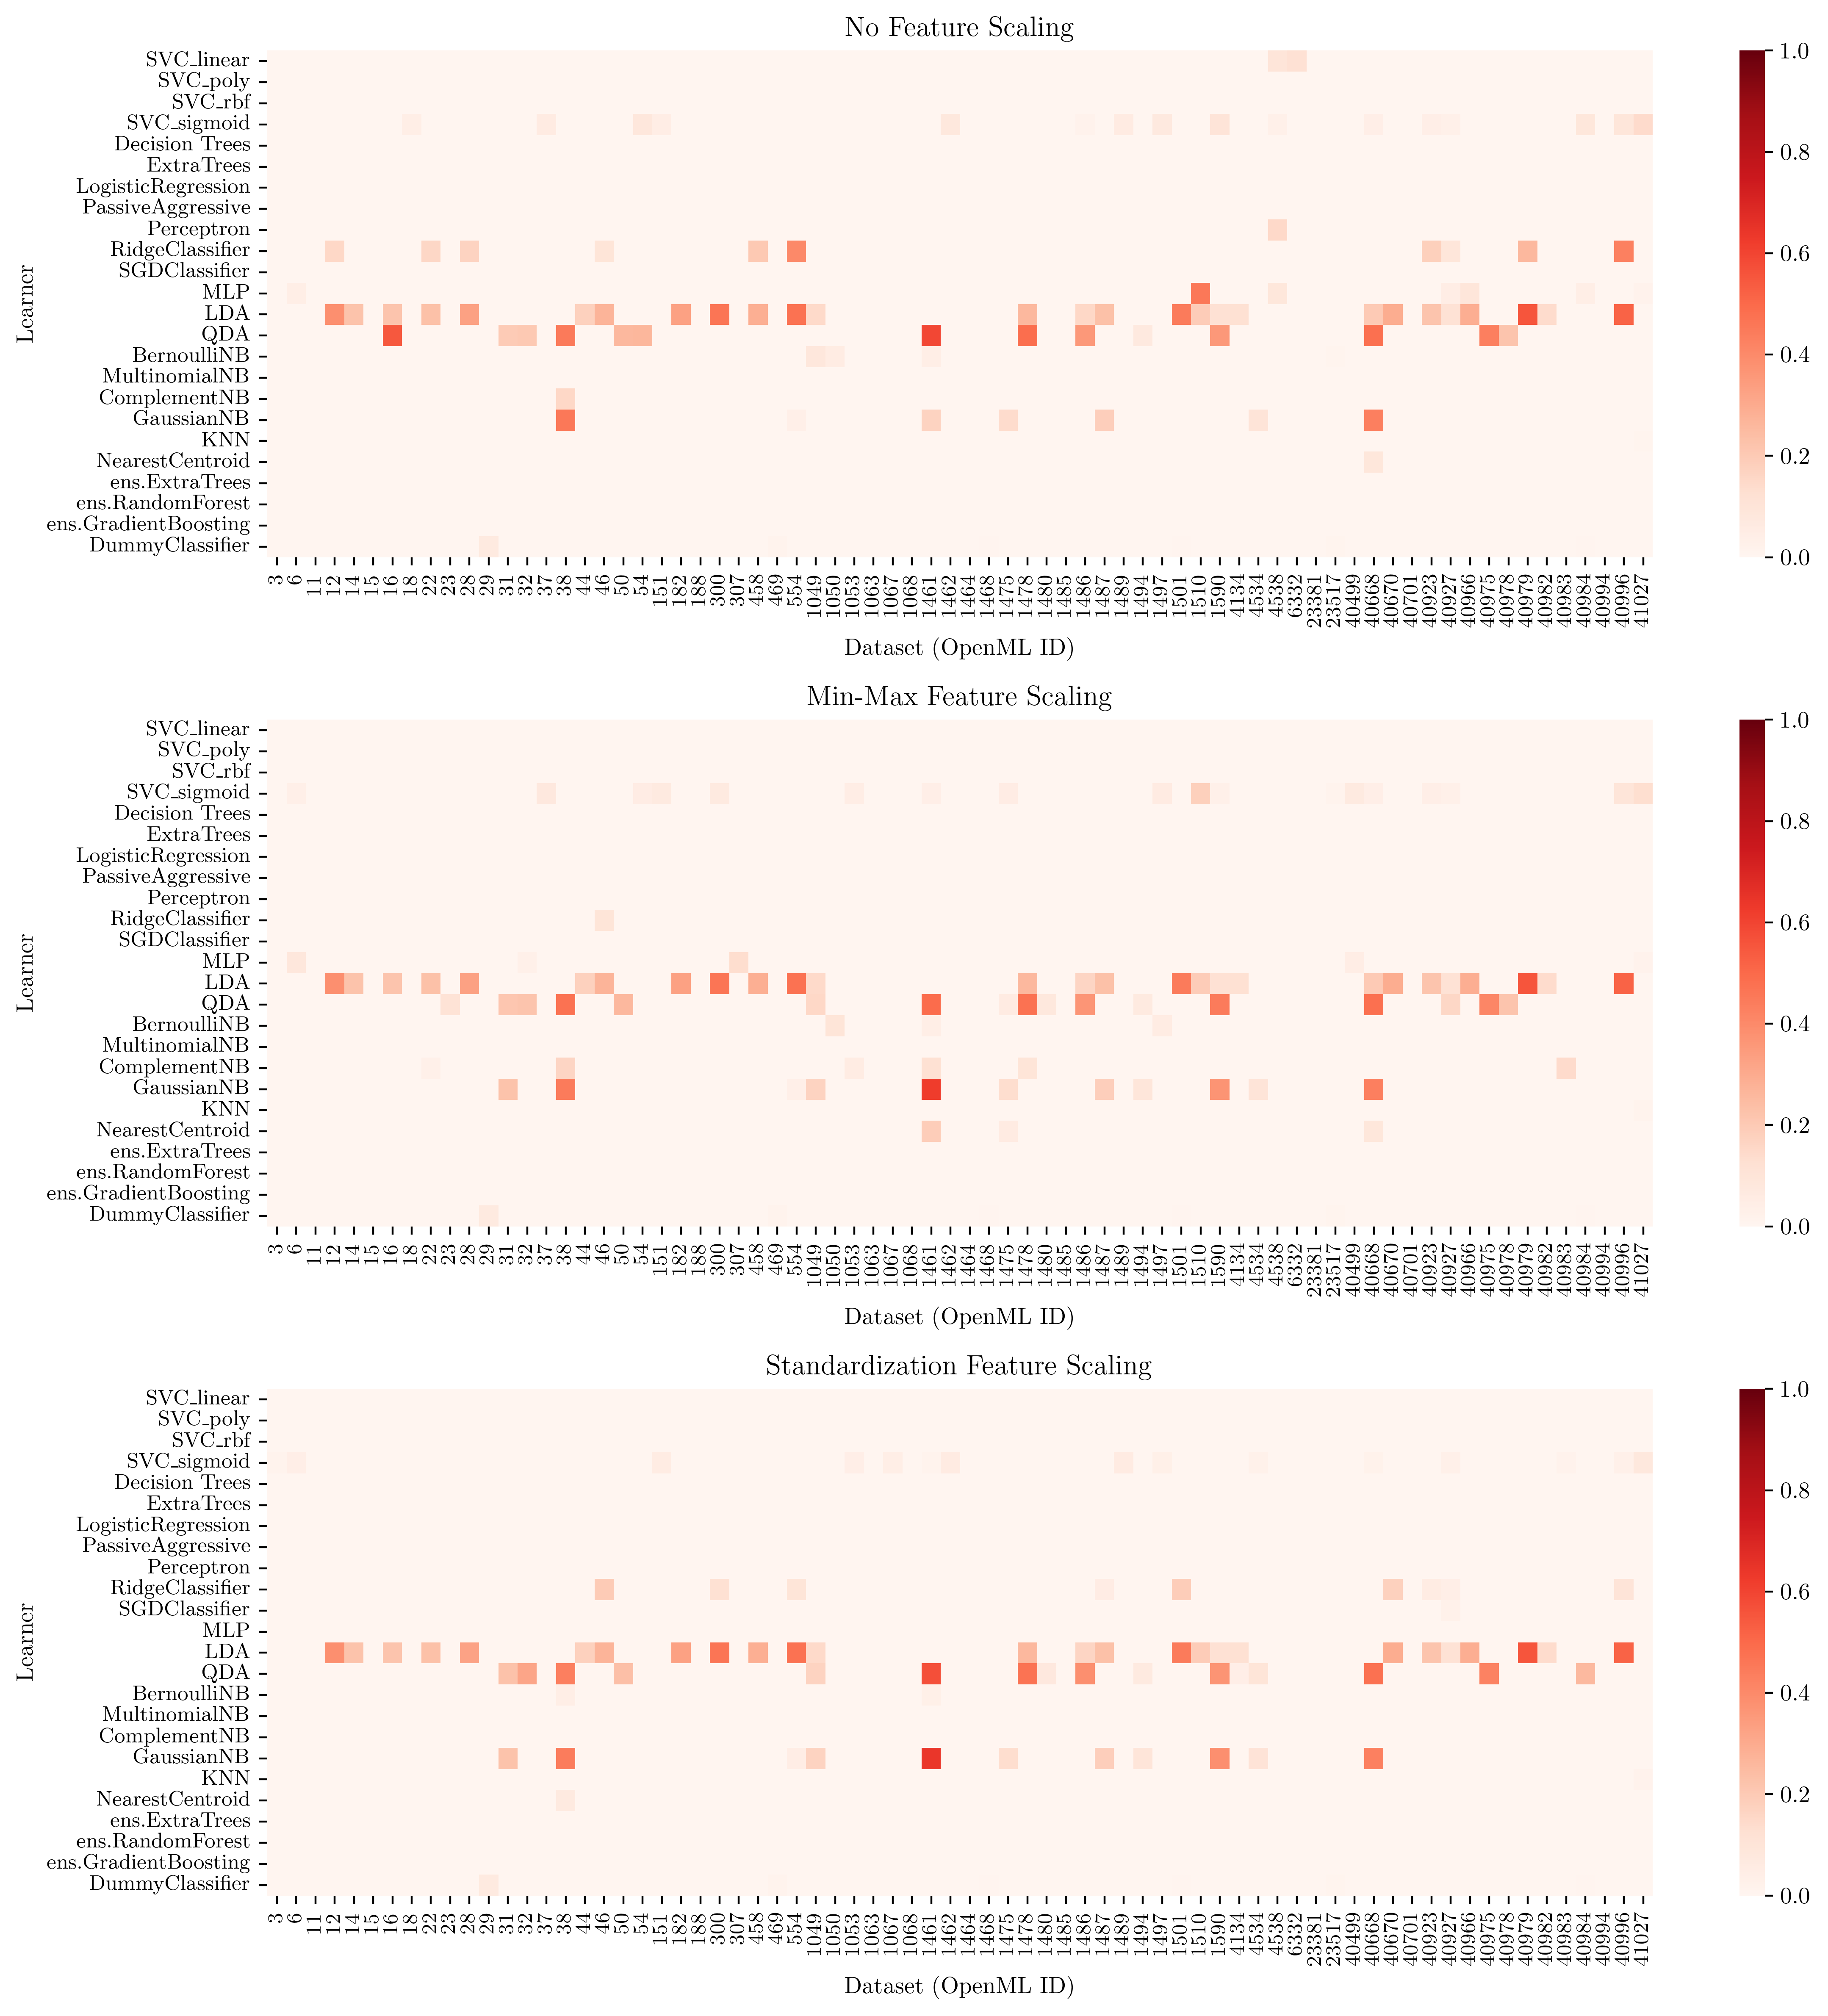

In [4]:
conv_matrices = [conv_matrix_nofs, conv_matrix_minmaxfs, conv_matrix_standardfs]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, conv_matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


In [5]:
percentages_nofs = (np.sum(conv_matrix_nofs > 0, axis=1) / conv_matrix_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(conv_matrix_minmaxfs > 0, axis=1) / conv_matrix_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(conv_matrix_standardfs > 0, axis=1) / conv_matrix_standardfs.shape[1]) * 100

# filter some learner
exclude_indices = [13, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

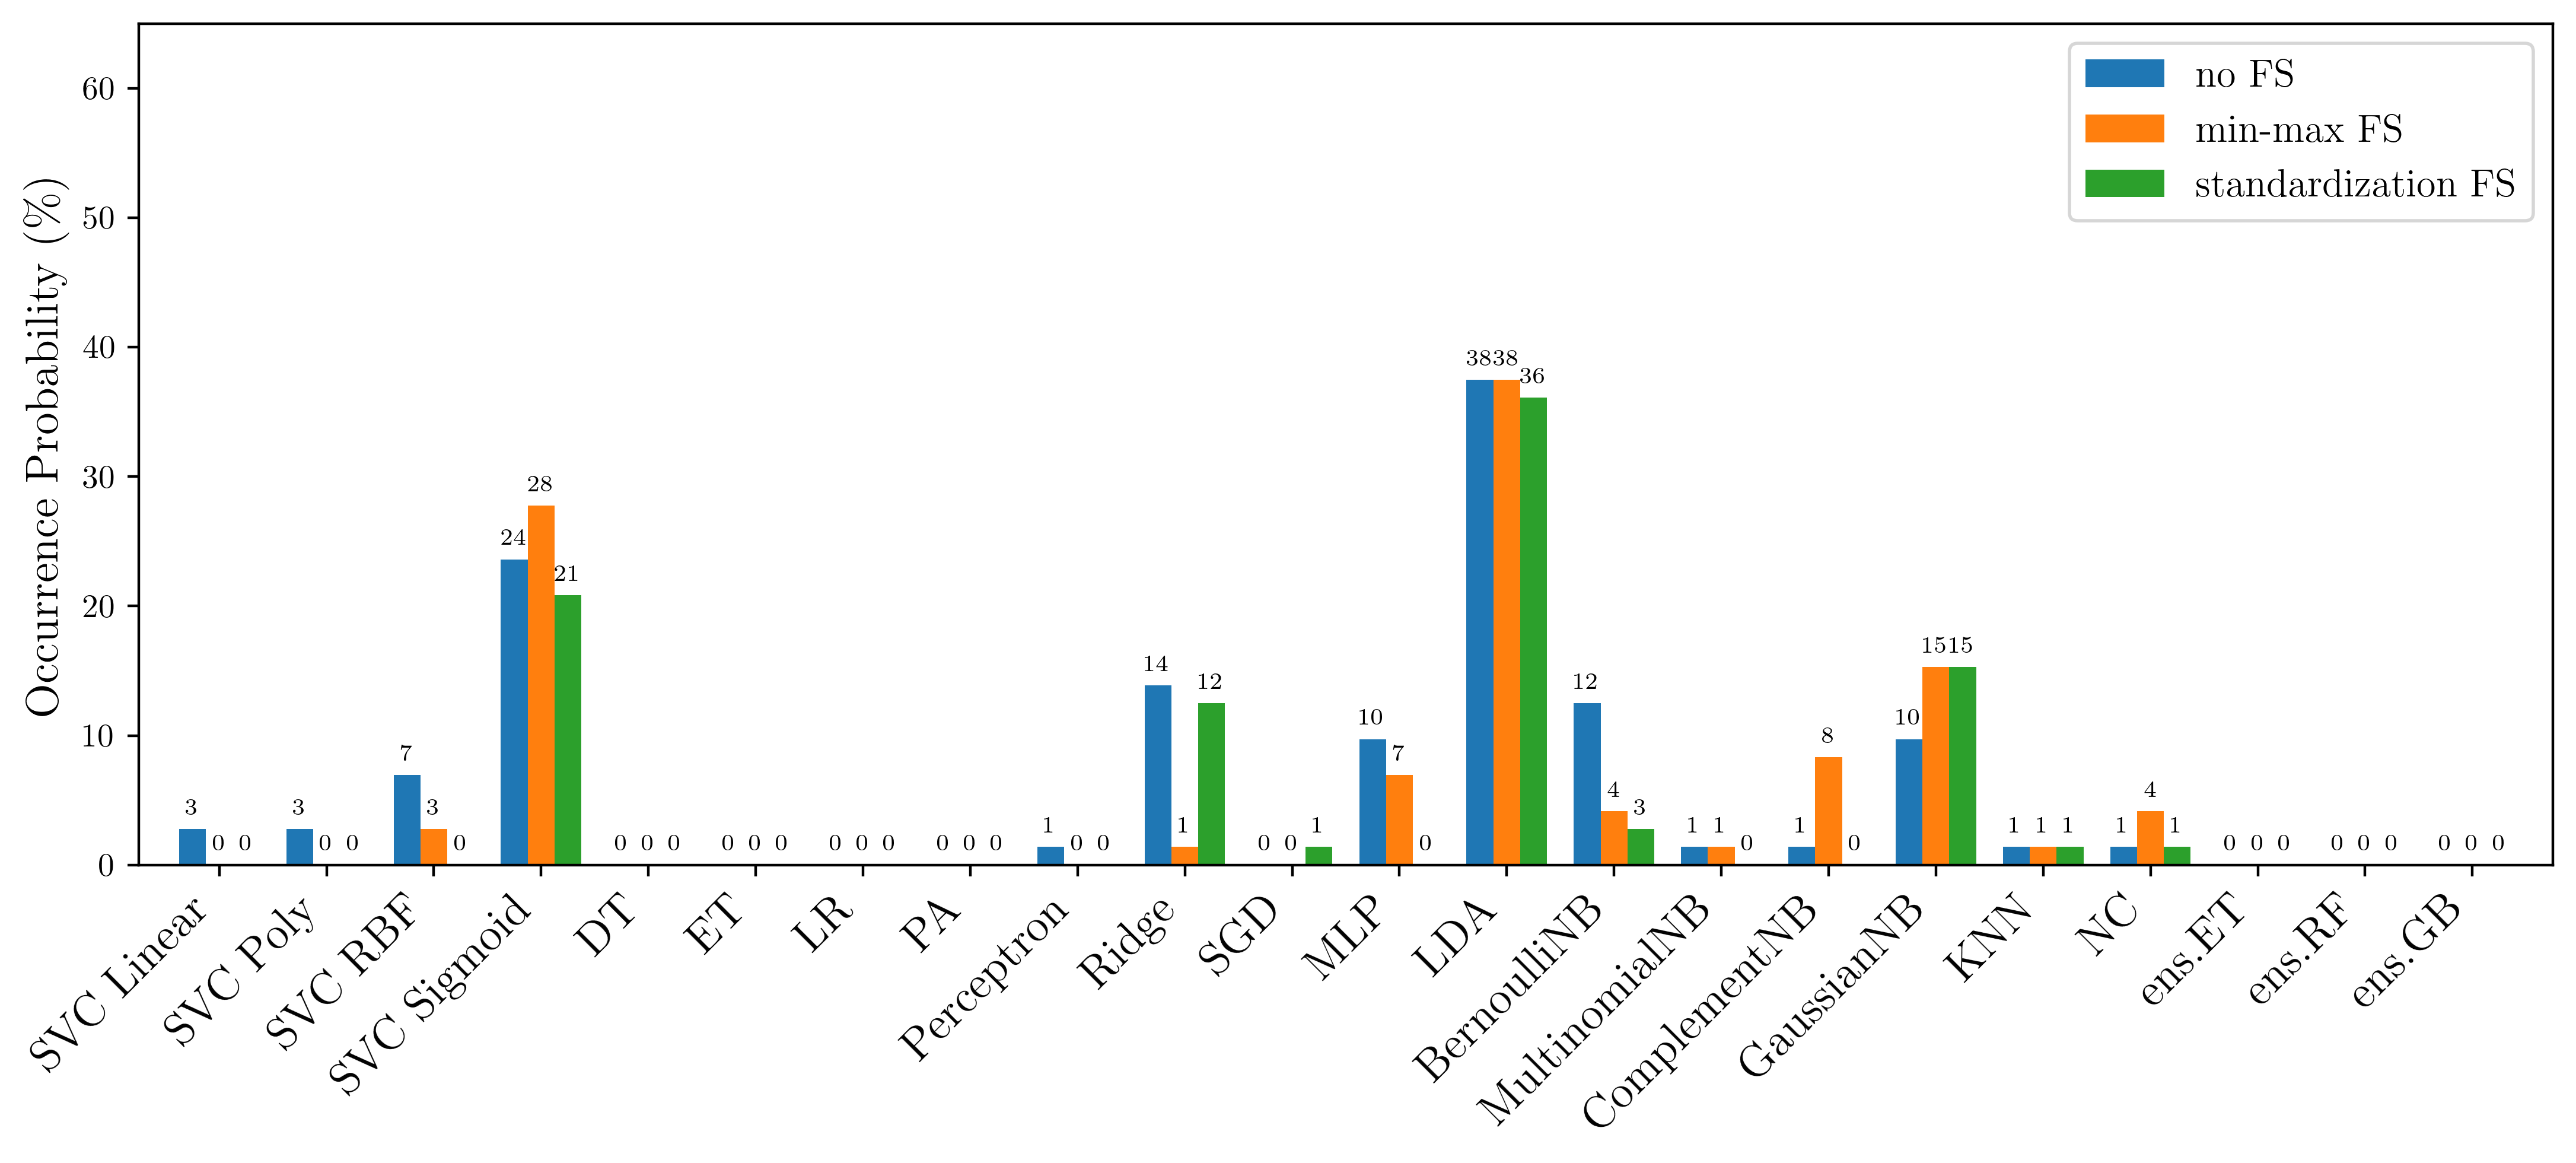

In [6]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(loc = 'best',fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### position of peak

##### MLP

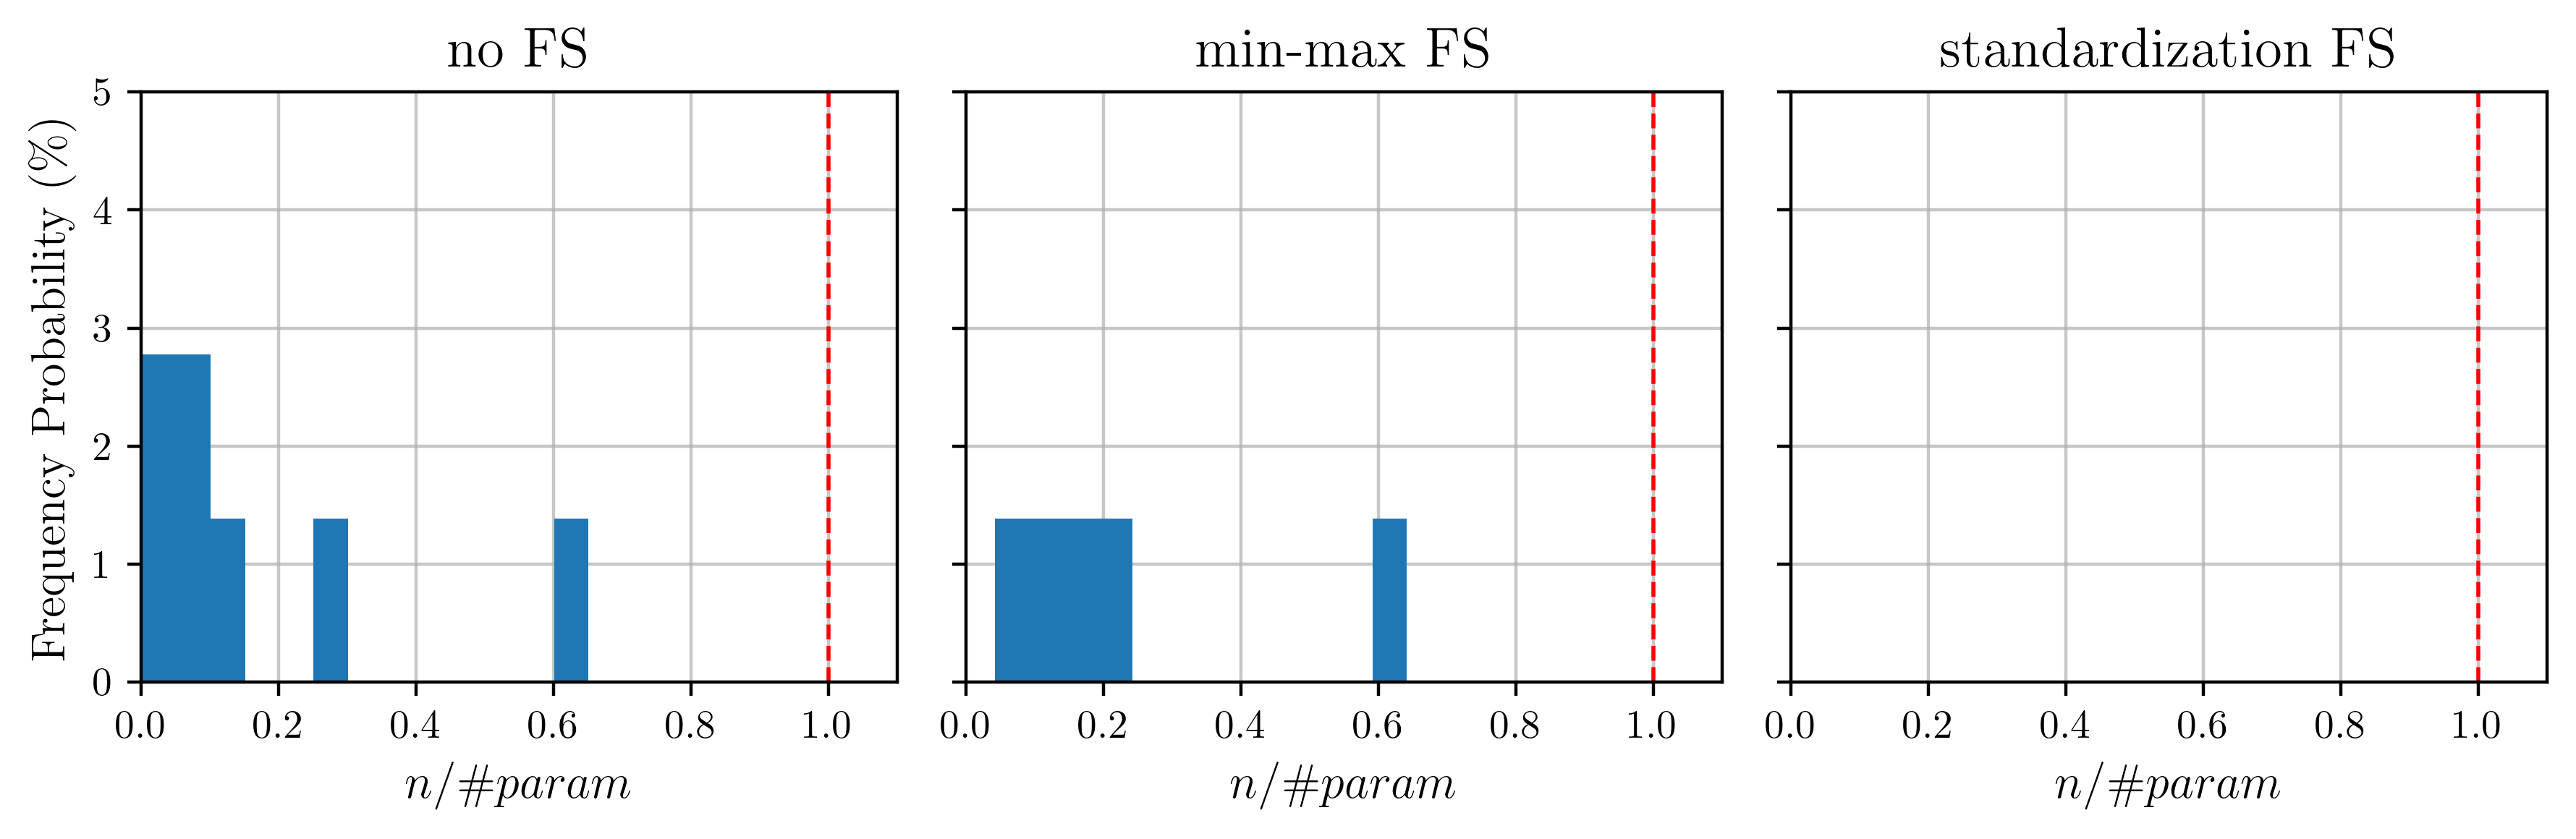

In [7]:
LEARNER = 11
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  # filter out no violation case
            continue

        peak_position = matrix[LEARNER, data_idx]
        ideal_peak = (feature_num_CC18[data_idx] + 1) * 100 + class_num_CC18[data_idx] * (100 + 1)
        ratio = peak_position / ideal_peak
        ratios.append(ratio)
    if len(ratios) > 0:
        bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
        n, bins, _ = ax.hist(ratios, bins=bins, density=False)
        n = (n / conv_i_matrix_nofs.shape[1]) * 100 # convert into %
        ax.cla()  
        ax.bar(bins[:-1], n, width=bin_width, align='edge')
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/\\#param$', fontsize=12)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 5)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()

dataset ID: 6, anchor: 609.0
dataset ID: 1510, anchor: 198.0
dataset ID: 4538, anchor: 108.0
dataset ID: 40927, anchor: 280.0
dataset ID: 40966, anchor: 609.0
dataset ID: 40984, anchor: 609.0
dataset ID: 41027, anchor: 609.0
dataset ID: 6, anchor: 609.0
dataset ID: 32, anchor: 609.0
dataset ID: 307, anchor: 609.0
dataset ID: 40499, anchor: 216.0
dataset ID: 41027, anchor: 609.0


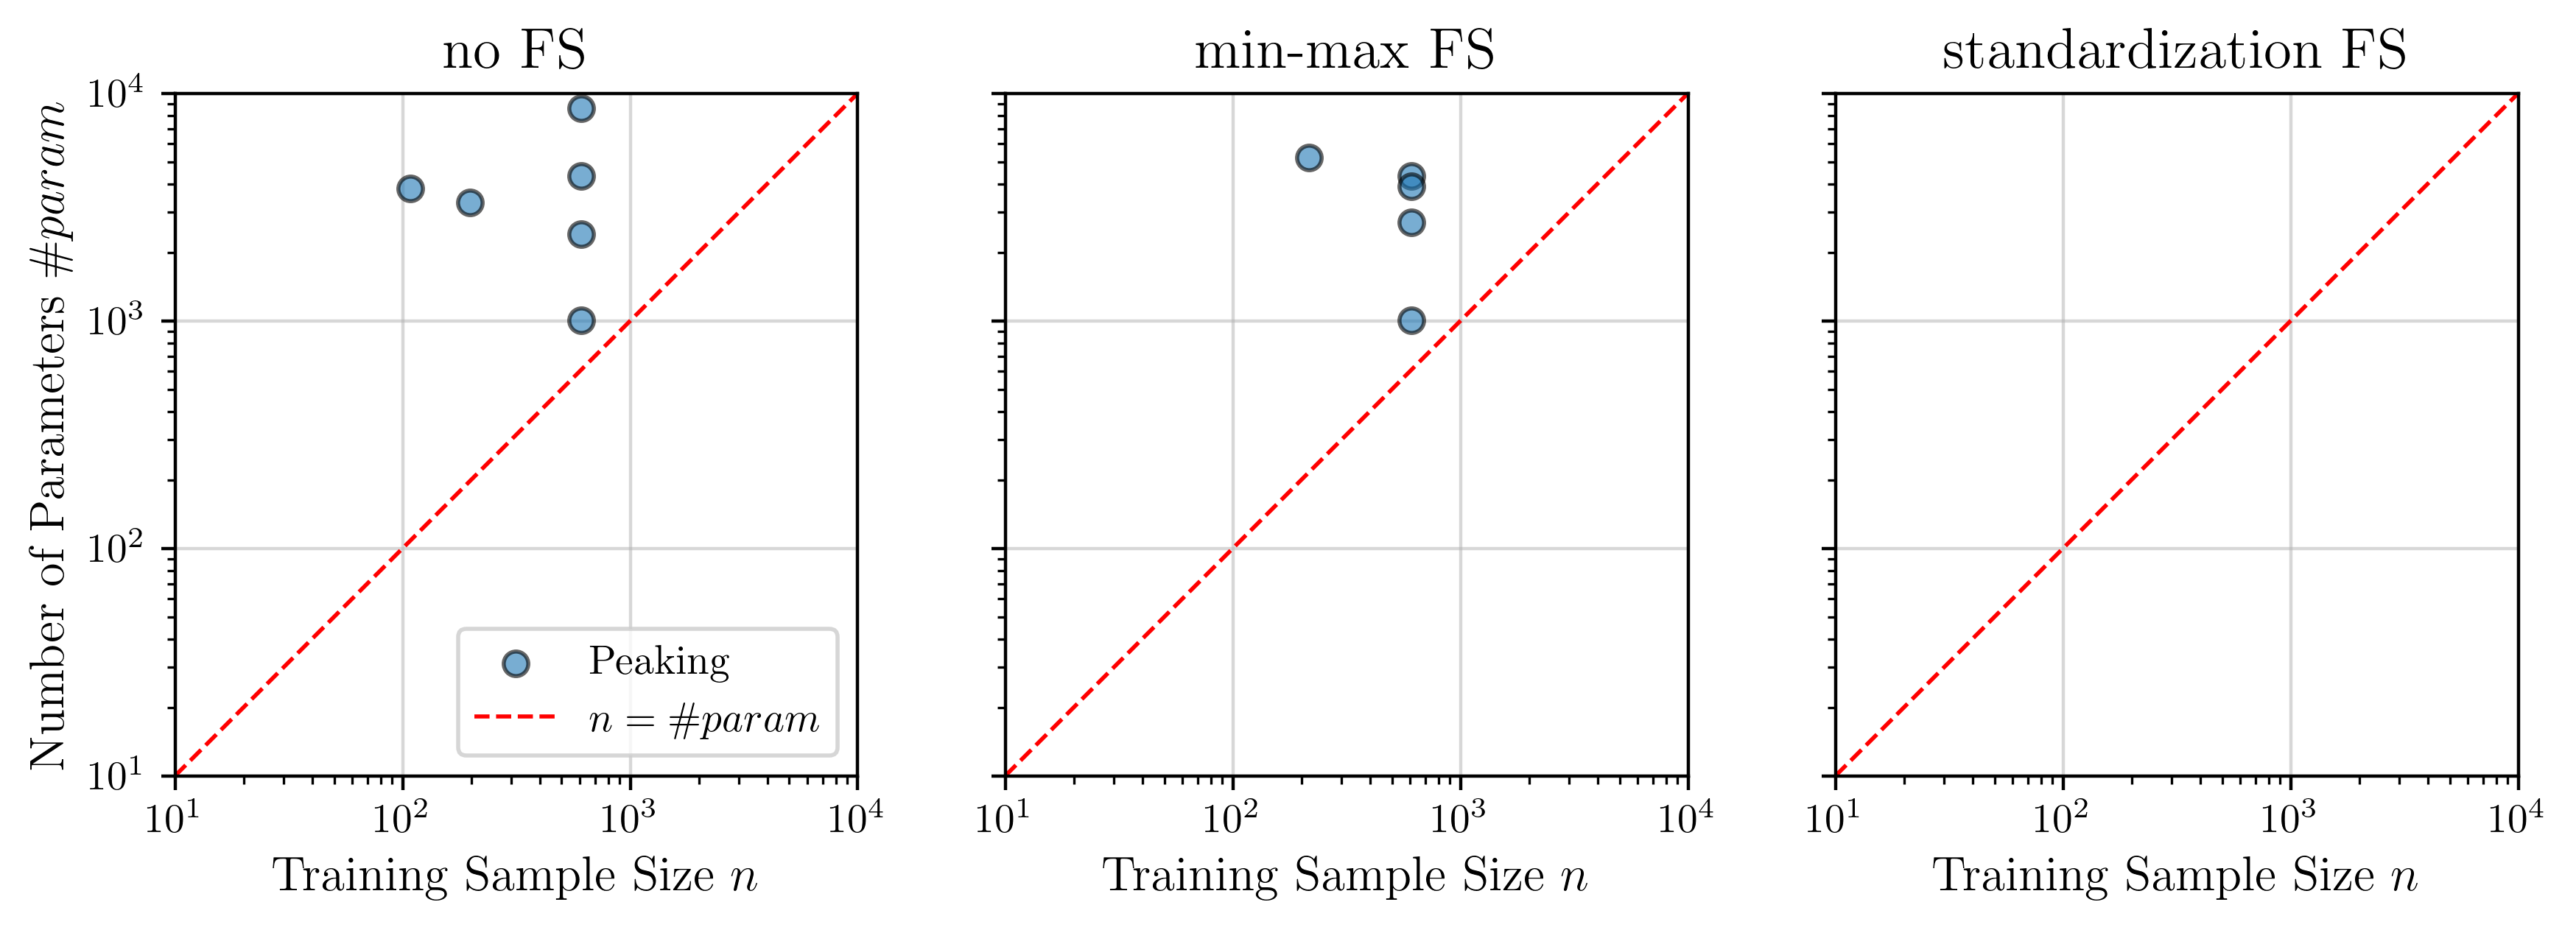

In [8]:
LEARNER = 11

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):

    n_values = []
    ideal_values = []

    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  # filter out no violation case
            continue

        peak_position = matrix[LEARNER, data_idx]
        ideal_peak = (feature_num_CC18[data_idx] + 1) * 100 + class_num_CC18[data_idx] * (100 + 1)
        print(f'dataset ID: {dataset_ids_CC18[data_idx]}, anchor: {peak_position}')
        n_values.append(peak_position)
        ideal_values.append(ideal_peak)

    ax.scatter(n_values, ideal_values, alpha=0.6, edgecolors='k', label='Peaking')

    d_range = np.logspace(np.log10(10), np.log10(10000), 100)
    ax.plot(d_range, d_range, 'r--', linewidth=1, label='$n = \\#param$')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Training Sample Size $n$', fontsize=12)
    ax.set_ylabel('Number of Parameters $\\#param$' if idx == 0 else "", fontsize=12)
    ax.set_xlim(10, 10000)
    ax.set_ylim(10, 10000)
    ax.set_title(title, fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.5)

axes[0].legend()

plt.tight_layout()
plt.show()


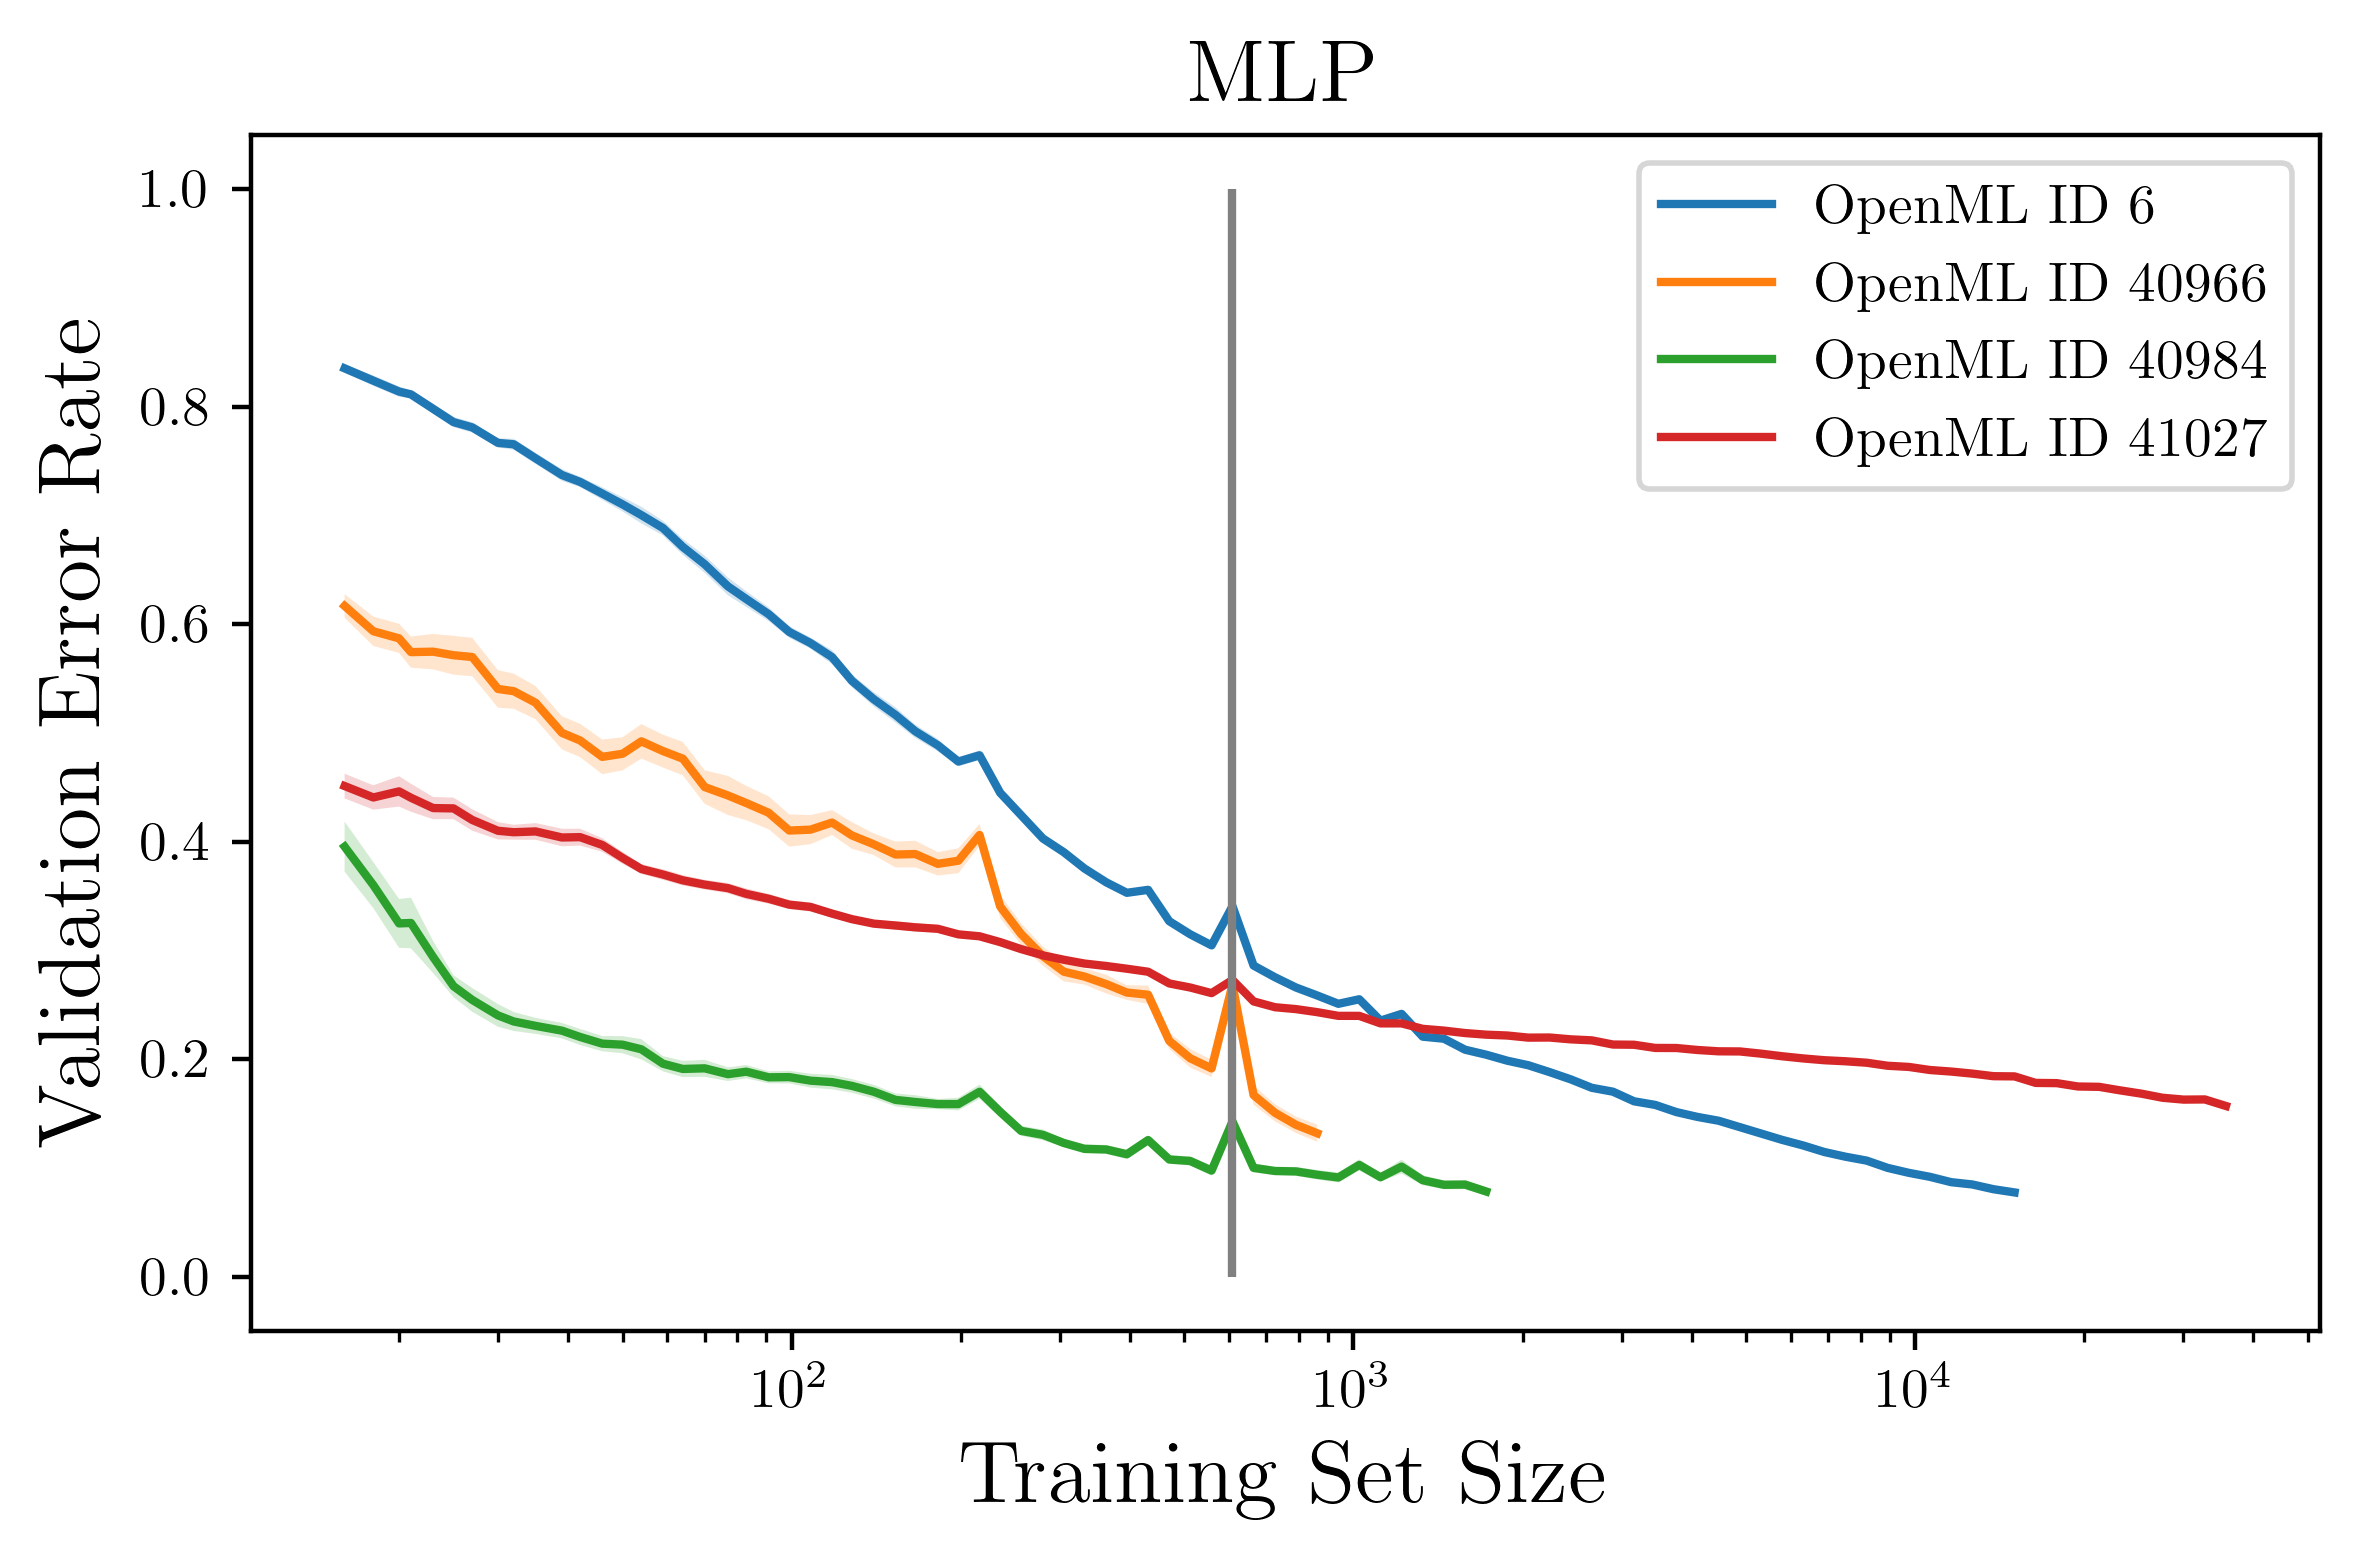

In [9]:
LEARNER = 11
DATASETS = [1, 62, 68, 71]

plt.figure(figsize=(6, 4), dpi=400)

for dataset_id in DATASETS:
    lc_clean = dataset_nofs[dataset_id, LEARNER, :, :, :, 1]
    mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
    se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

    label = f"OpenML ID {dataset_ids_CC18[dataset_id]}"
    plt.plot(anchor_list_denser, mean_clean, label=label)
    plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

plt.vlines(x=609, ymin=0, ymax=1, colors="grey")
plt.title(f'{learner_zoo[LEARNER]}', fontsize=16)
plt.xlabel('Training Set Size', fontsize=16)
plt.ylabel('Validation Error Rate', fontsize=16)
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


##### LDA

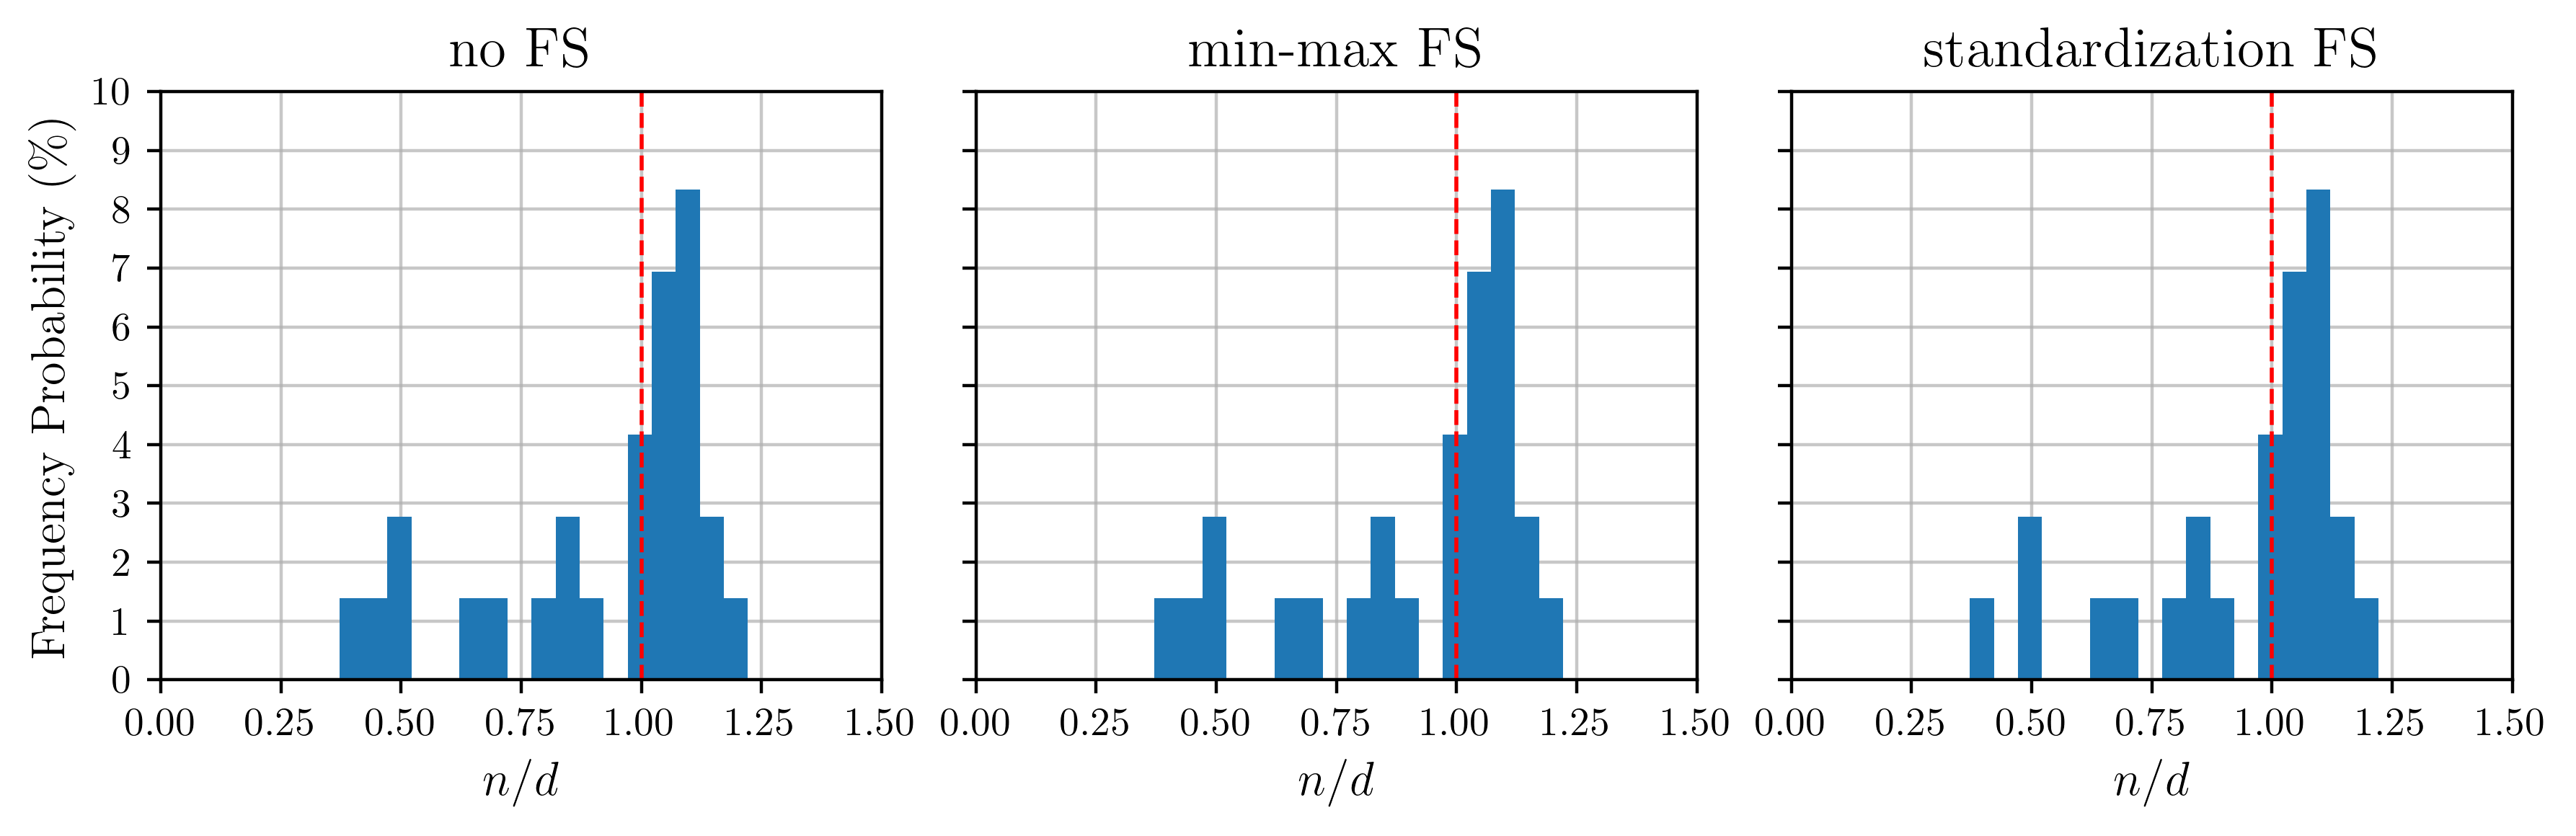

In [10]:
LEARNER = 12
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  # filter out no violation case
            continue

        peak_position = matrix[LEARNER, data_idx]
        ideal_peak = feature_num_CC18[data_idx]
        ratio = peak_position / ideal_peak
        ratios.append(ratio)
    if len(ratios) > 0:
        bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
        n, bins, _ = ax.hist(ratios, bins=bins, density=False)
        n = (n / conv_i_matrix_nofs.shape[1]) * 100 # convert into %
        ax.cla()  
        ax.bar(bins[:-1], n, width=bin_width, align='edge')
        
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/d$', fontsize=12)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 10)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()

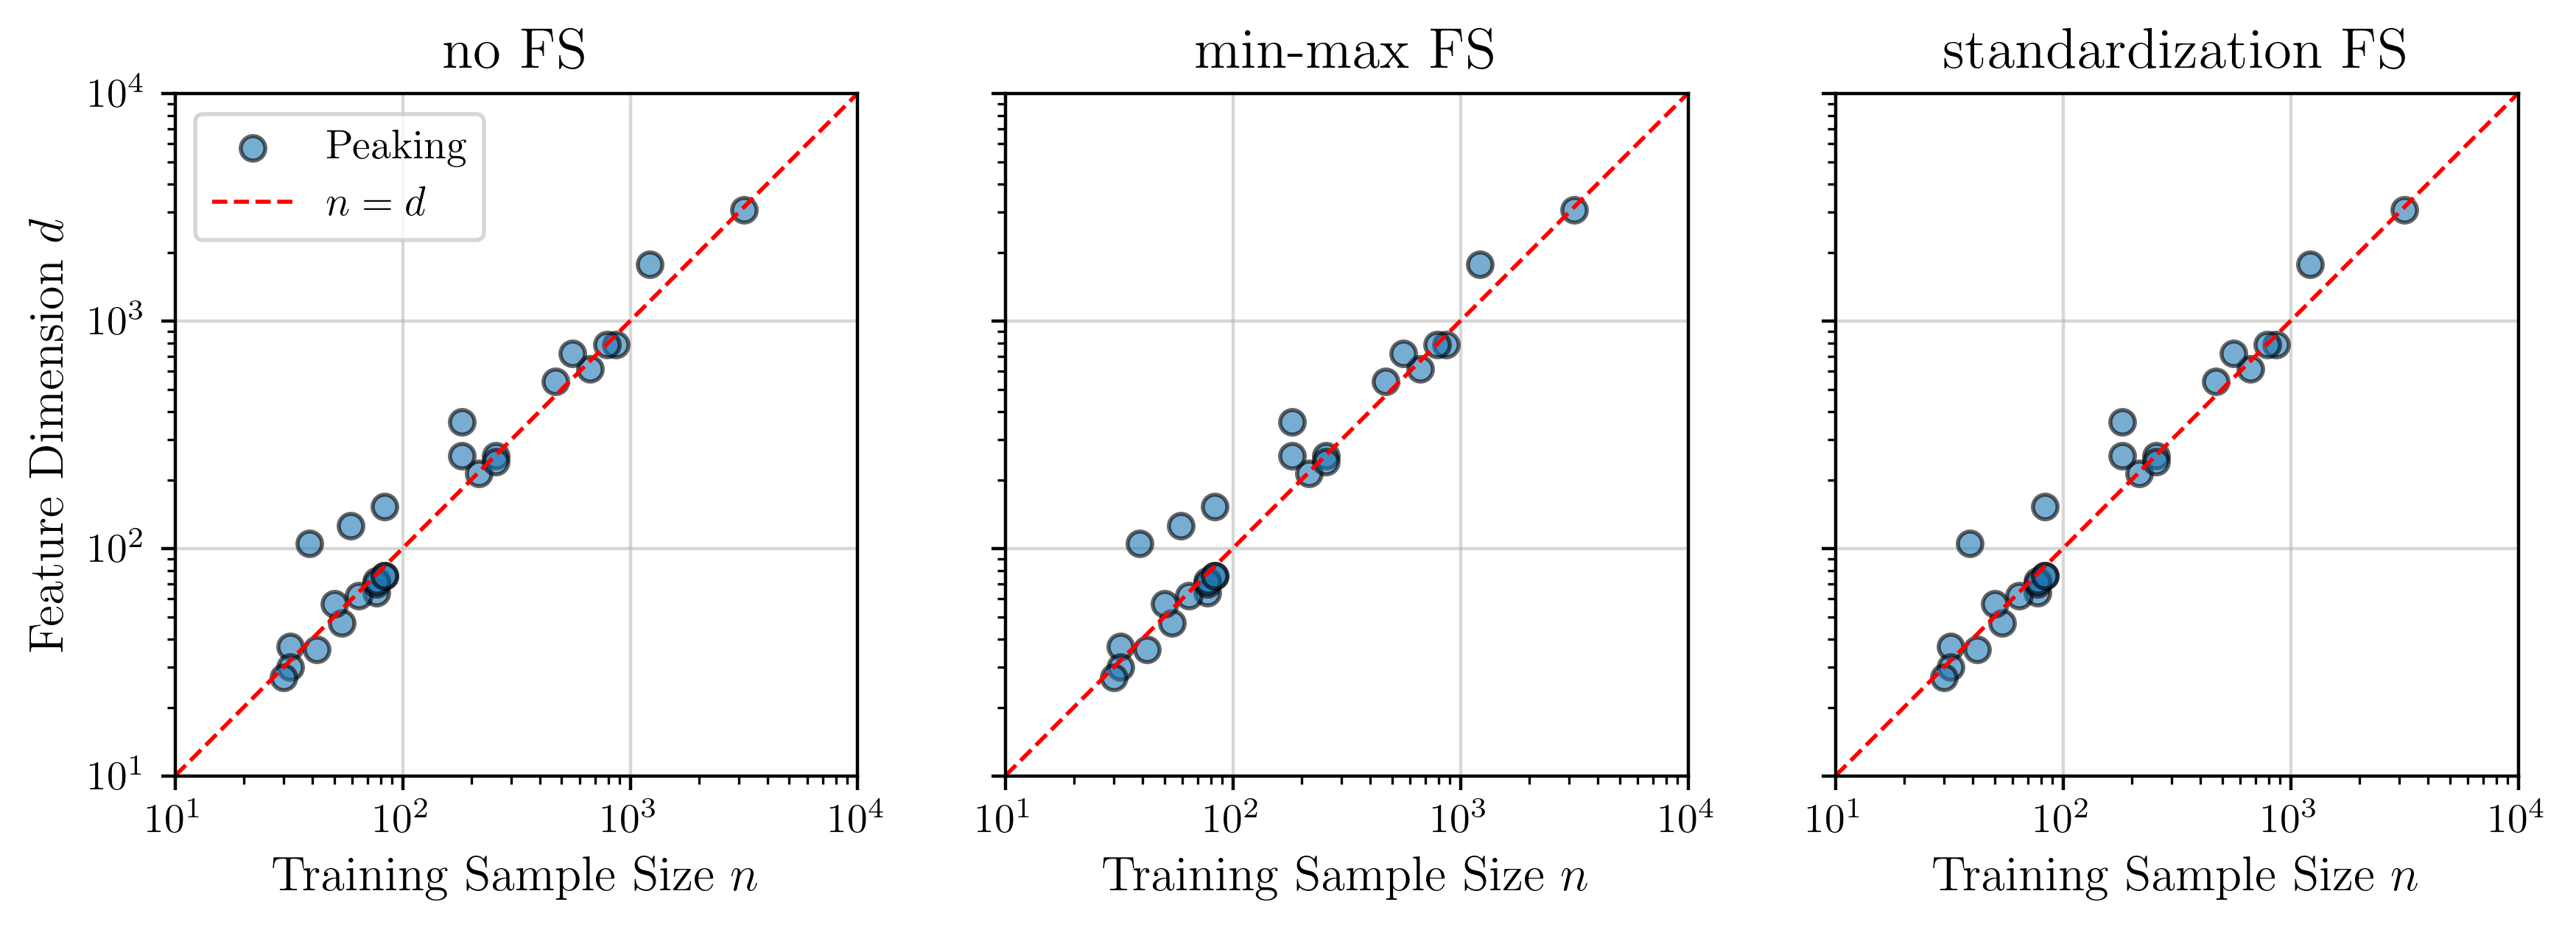

In [11]:
LEARNER = 12

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):

    n_values = []
    d_values = []

    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  
            continue

        peak_position = matrix[LEARNER, data_idx] 
        ideal_peak = feature_num_CC18_remove_redundancy[data_idx] 
        n_values.append(peak_position)
        d_values.append(ideal_peak)

    ax.scatter(n_values, d_values, alpha=0.6, edgecolors='k', label='Peaking')

    d_range = np.logspace(np.log10(10), np.log10(10000), 100)
    ax.plot(d_range, d_range, 'r--', linewidth=1, label='$n = d$')

    ax.set_xlabel('Training Sample Size $n$', fontsize=12)
    ax.set_ylabel('Feature Dimension $d$' if idx == 0 else "", fontsize=12)
    ax.set_xlim(10, 10000)
    ax.set_ylim(10, 10000)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title, fontsize=14)
    ax.set_axisbelow(True)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.5)

axes[0].legend()

plt.tight_layout()
plt.show()


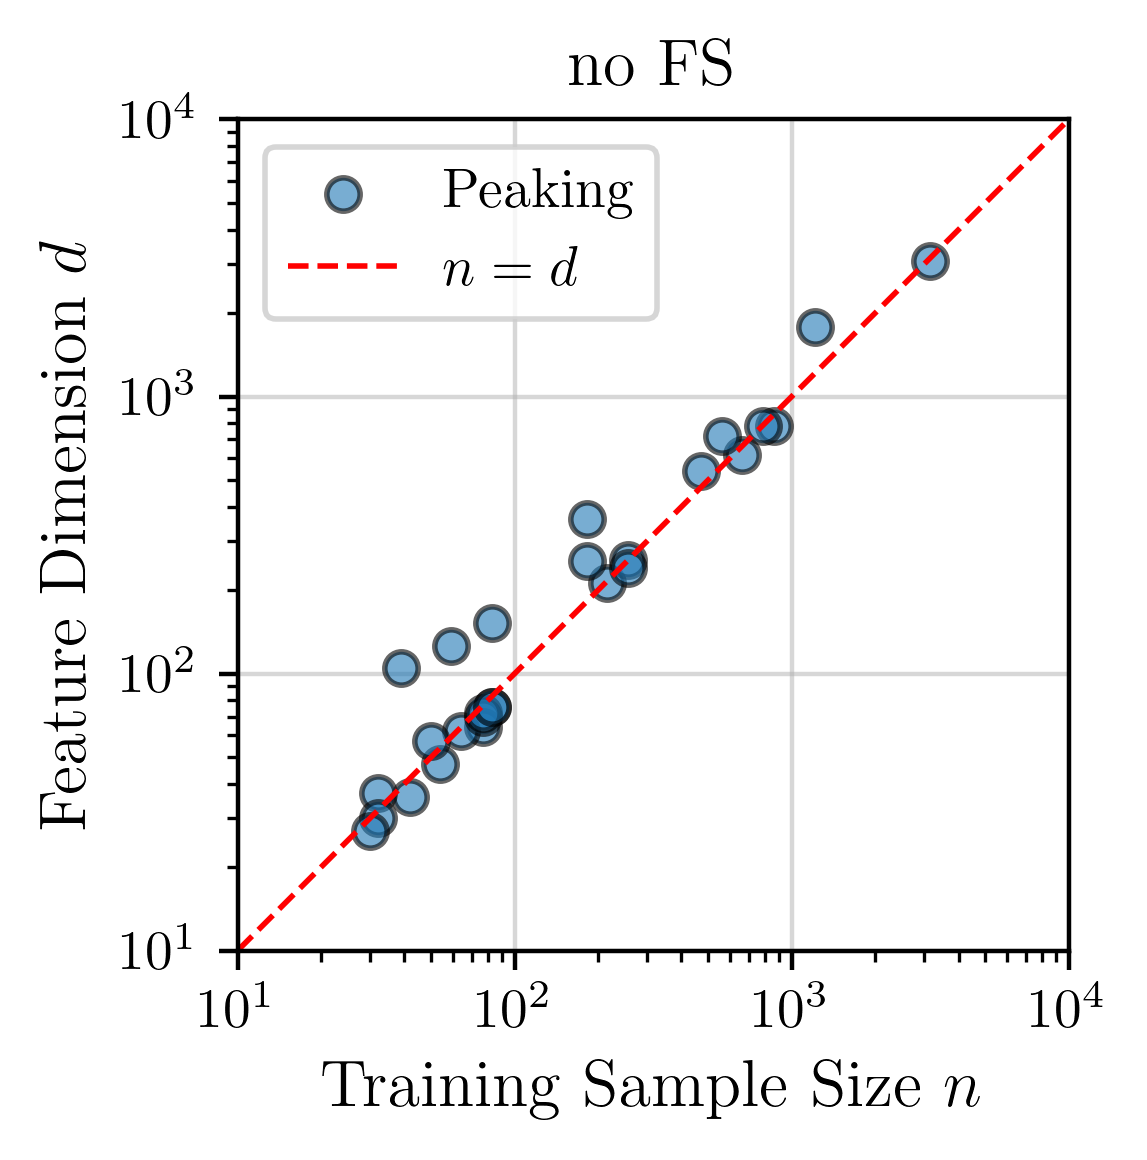

In [12]:
LEARNER = 12
fig, ax = plt.subplots(figsize=(3, 3), dpi=400) 
matrix = conv_i_matrix_nofs 
n_values = []
d_values = []

for data_idx in range(conv_i_matrix_nofs.shape[1]):
    if np.isnan(matrix[LEARNER, data_idx]):
        continue
    peak_position = matrix[LEARNER, data_idx]
    ideal_peak = feature_num_CC18_remove_redundancy[data_idx]
    n_values.append(peak_position)
    d_values.append(ideal_peak)

ax.scatter(n_values, d_values, alpha=0.6, edgecolors='k', label='Peaking')

d_range = np.logspace(np.log10(10), np.log10(10000), 100)
ax.plot(d_range, d_range, 'r--', linewidth=1, label='$n = d$')

ax.set_xlabel('Training Sample Size $n$', fontsize=12)
ax.set_ylabel('Feature Dimension $d$', fontsize=12)
ax.set_xlim(10, 10000)
ax.set_ylim(10, 10000)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.5)
ax.set_axisbelow(True)

ax.set_title("no FS", fontsize=12)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
